# MetroGauss
The aim is to generate gausiian number with given average and given variance using a Metropolis Algorithm as a toy model 

In [29]:
import numpy as np
from tqdm.notebook import tqdm
from time import sleep
import pylab
import os
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use(['science','notebook','grid'])
import numba
from numba import njit

from numba import prange
from numba_progress import ProgressBar
from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer

### pseudo-random generator test

In [ ]:
record = open("metrogauss1.txt","w")

In [558]:
nstat =int(10e5)
start=0.0
avg=5.0
var=1
delta=0.1
qq=np.zeros(nstat)


In [ ]:
#Let's initialiaze the state of the system
#i markov chain step 
q=start
for i in range(1,10**6):
    x,y= np.random.uniform(0,1,2)
    q_try=q + delta*(1.0-2.0*x) #mi muovo di +- delta attorno al vecchio valore 
    
    z = np.exp(((q-avg)**2)-(q_try-avg)**2)/(2*var)   # ratio of probab
    
    if(y<z):
        q=q_try
        acc=1.0
    else:
        acc=0.0
    record.write("%d       "%i)
    record.write("%f       "%q)
    record.write("%f       "%acc)
    
    record.write("\n")

In [ ]:
count, bins, ignored = plt.hist(x, 15, density=True)
>>> plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
>>> plt.show()

In [ ]:
i,j,k= pylab.loadtxt('metrogauss1.txt', unpack=True)
plt.plot(i,j)

In [ ]:
cwd = os.getcwd()
filename = 'metrogauss1.txt'
file=open(os.path.join(cwd,filename),"w")


## Let's test the performance for future projects

In [441]:
def sampling_distribution(qq, start, avg, var, delta, nstat):
    qq[:]=0
    qq[0]=start
    acc=np.zeros(nstat)
    for i in tqdm(range(1,nstat)):
        x= np.random.uniform(0,1)
        y= np.random.uniform(0,1)
        q_try=qq[i-1] + delta*(1.0-2.0*x) #mi muovo di +- delta attorno al vecchio valore 
    
        z = np.exp(((qq[i-1]-avg)**2)-(q_try-avg)**2)/(2*var)   # ratio of probab
    
        if(y<z):
            qq[i]=q_try
            acc[i]=1.0
        else:
            qq[i]=qq[i-1]
            acc[i]=0.0
        
#         if(i%1000000==0):
#            print(i)
        
    return qq, acc
        
    
    

  0%|          | 0/9999 [00:00<?, ?it/s]

CPU times: user 149 ms, sys: 3.24 ms, total: 152 ms
Wall time: 51.3 ms


4.939761682302967

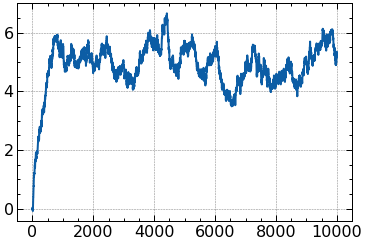

In [461]:

%time qq, acc = sampling_distribution(qq, start, avg, var, delta, nstat)
plt.plot(qq)
mean_val=np.sum(qq[2000:])/(nstat-2000)
mean_val

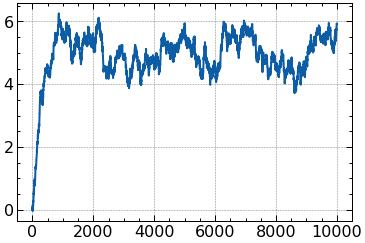

In [465]:
@njit    #spedup
def spedup_sampling_distribution(qq,start, avg, var, delta, nstat):
    qq[:]=0
    qq[0]=start
    acc=np.zeros(nstat)
    for i in range(1,nstat):
        x= np.random.uniform(0,1)
        y= np.random.uniform(0,1)
        q_try=qq[i-1] + delta*(1.0-2.0*x) #mi muovo di +- delta attorno al vecchio valore 
    
        z = np.exp(((qq[i-1]-avg)**2)-(q_try-avg)**2)/(2*var)   # ratio of probab
        if(y<z):
            qq[i]=q_try
            acc[i]=1.0
        else:
            qq[i]=qq[i-1]
            acc[i]=0.0        
    return qq, acc    

In [474]:
#strt=timer()
%time tt, acc = spedup_sampling_distribution(qq, start, avg, var, delta, nstat)
#end=timer()
#print(end - strt)

CPU times: user 512 µs, sys: 5 µs, total: 517 µs
Wall time: 522 µs


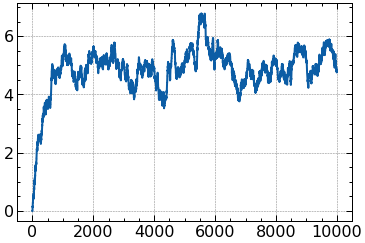

In [475]:
plt.plot(tt)

In [ ]:
@numba.njit("UniTuple(f8[:], 2)(f8[:],f8, f8, f8, f8, i8)", nopython=True, nogil=True)
def sspedup_sampling_distribution(qq, start, avg, var, delta, nstat):
    qq[0]=start
    acc=np.zeros(nstat)
    for i in range(1,nstat):
        x= np.random.uniform(0,1)
        y= np.random.uniform(0,1)
        q_try=qq[i-1] + delta*(1.0-2.0*x) #mi muovo di +- delta attorno al vecchio valore 
    
        z = np.exp(((qq[i-1]-avg)**2)-(q_try-avg)**2)/(2*var)   # ratio of probab
    
        if(y<z):
            qq[i]=q_try
            acc[i]=1.0
        else:
            qq[i]=qq[i-1]
            acc[i]=0.0        
    return qq, acc

In [ ]:
strt=timer()
qq, acc = sspedup_sampling_distribution(qq, start, avg, var, delta, nstat)
end=timer()
print(end - strt)

In [ ]:
i=np.arange(0,nstat)
np.savetxt('gaussian_sampling.txt',np.column_stack([i,qq,acc]), delimiter='\t \t', newline='\n',
          header='iteration \t \t sample values \t \t acceptance')

In [ ]:
N=nstat-2000

mean_val=np.sum(qq[2000:])/(nstat-2000)
plt.figure(figsize=(15,8))
plt.plot(qq[2000:])
plt.plot(qq, color='r',linewidth=.5 )

var=np.var(qq[2000:])
var1= 1/(N)* 1/(N-1)*np.sum((qq[2000:]-mean_val)**2)  #central limit theorem (errore naive)
var= 1/N*np.sum((qq[2000:]-mean_val)**2)      #same of np.var()
var_numpy =np.var(qq[2000:])
mean_val, var1**(1/2), var**(1/2), var_numpy**(1/2)

In [ ]:
#Let's try to load the text from the file that we have just written in order to understand if it's easy to manipulate these files

it, qqq, accc= np.loadtxt('gaussian_sampling.txt', unpack=True)
np.mean(qqq[2000:])

#so it's how we thaught

In [ ]:
@njit
def error_sampling_distribution(qq, start, avg, var, delta, nstat):
    qq[:]=0
    qq[0]=start
    acc=np.zeros(nstat)
    for i in range(1,nstat):
        x= np.random.uniform(0,1)
        y= np.random.uniform(0,1)
        q_try=qq[i-1] + delta*(1.0-2.0*x) #mi muovo di +- delta attorno al vecchio valore 
    
        #z = np.exp(((qq[i-1]-avg)**2)-(q_try-avg)**2)/(2*var)   # ratio of probab
        z =  np.exp(((qq[i-1]-avg)**2)-(q_try-avg)**2)/(2*var)
        if(y<z):
            qq[i]=q_try
#            acc[i]=1.0
        else:
            qq[i]=qq[i-1]
#            acc[i]=0.0
        
    return qq


In [ ]:

qq=error_sampling_distribution(qq, start, avg, var, delta, nstat)
plt.plot(qq)
media= np.sum(qq[2000:])/(nstat-2000)
var1= 1/(nstat-2000)* 1/(nstat-2000-1)*np.sum((qq[2000:]-media)**2)
media,var1

In [ ]:
def means_forerror(dim):
    means=np.zeros(dim)
    for i in range(dim):   
        means[i]=np.sum(error_sampling_distribution(qq, start, avg, var, delta, nstat)[5000:])/(nstat-5000)
    return means

In [ ]:
means = means_forerror(1000)
plt.figure(figsize=(18,10))
plt.ylim(3,7)
plt.plot(means, '.', color='black' )

In [ ]:
plt.plot(tt)

In [ ]:
plt.plot(qq)

In [ ]:
means[5]

# Proper way to estimate the stat error (autocorrelation) 

(4.959888008097334,
 0.0005116519943360211,
 0.5111398301772699,
 0.5111398301772699)

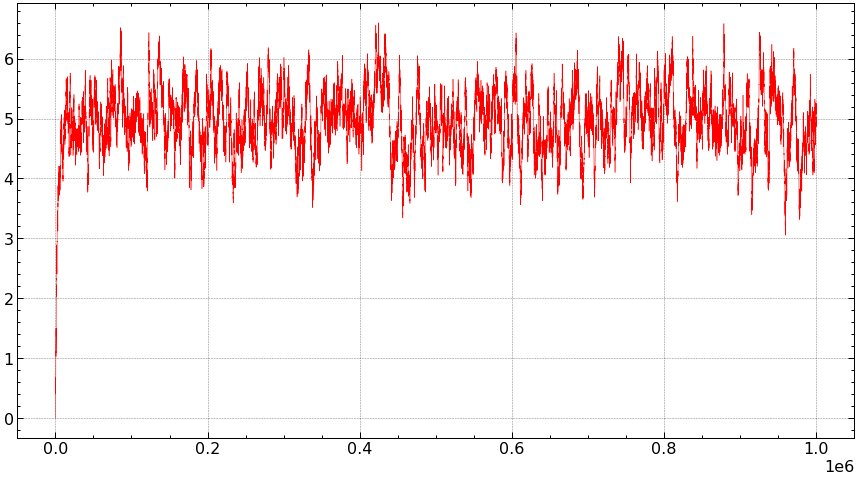

In [563]:
N=nstat-2000
qq=np.zeros(nstat)
qq, acc= spedup_sampling_distribution(qq,start, avg, var, delta, nstat)
mean_val=np.sum(qq[2000:])/(nstat-2000)
plt.figure(figsize=(15,8))

plt.plot(qq, color='r',linewidth=.5 )

var=np.var(qq[2000:])
var1= 1/(N)* 1/(N-1)*np.sum((qq[2000:]-mean_val)**2)  #central limit theorem (errore naive)
var= 1/N*np.sum((qq[2000:]-mean_val)**2)      #same of np.var()
var_numpy =np.var(qq[2000:])
mean_val, var1**(1/2), var**(1/2), var_numpy**(1/2)

In [568]:
corr= np.zeros(4000)
sample = qq[2000:]
N=len(sample)
for i in tqdm(range(len(corr))):
    for j in range(1,len(sample)-i):
        corr[i]+=1/((N-i))*(sample[j]- mean_val)*(sample[j+i]-mean_val)*(1/var1)*(1/N)

  0%|          | 0/4000 [00:00<?, ?it/s]

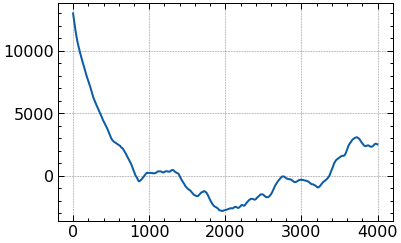

In [551]:
plt.plot(corr)

In [566]:
#spedup
@njit
def auto_corr(sample):
    corr= np.zeros(10000)
    sample = qq[2000:]
    N=len(sample)
    for i in range(len(corr)):
        for j in range(1,len(sample)-i):
            corr[i]+=1/((N-i))*(sample[j]- mean_val)*(sample[j+i]-mean_val)*(1/var1)*(1/N)
    return corr
    

CPU times: user 11.4 s, sys: 30.3 ms, total: 11.4 s
Wall time: 11.4 s


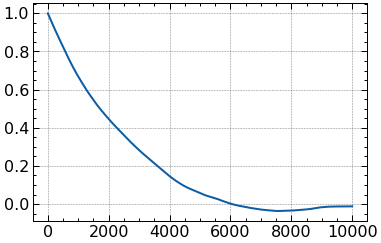

In [567]:
sample=qq[2000:]
%time corr=auto_corr(sample)
plt.plot(corr)

# Blocking 